# ENERGY CONSUMPTION PREDICTION

The Project is the prediction of the Power Consuption of the whole country depending on the county.The consumption determines the prices, The most users and To determine the Profits of the Company. In this project, I used Machine Learning Algorithms to determine the future and gowth of the energy sector.

In [69]:
#importing necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import panel as pn
plt.style.use('ggplot')
import os
import tarfile
from six.moves import urllib
pn.extension('tabulator')
import lightgbm as lgbm

import hvplot.pandas

%matplotlib inline

In [2]:
#Loading dataset

df = pd.read_excel("KplcData/Daset.xlsx") 
df


,PERIOD,REGION,COUNTY,ACC,MTR,COD_TARIFF,INSTALLATION_DATE,UNITS
0,202102,COAST,MOMBASA,86579721,57100062272,A0-1 DC-L,2020-12-04,0.0
1,201801,NAIROBI WEST,NAIROBI WEST,86579721,57100062272,A0-1,2020-12-04,54.0
2,201802,NAIROBI WEST,NAIROBI WEST,86579721,57100062272,A0-1,2020-12-04,100.0
3,201803,NAIROBI WEST,NAIROBI WEST,86579721,57100062272,A0-1,2020-12-04,0.0
4,201804,NAIROBI WEST,NAIROBI WEST,86579721,57100062272,A0-1,2020-12-04,76.0
...,...,...,...,...,...,...,...,...
201403,202010,COAST,MOMBASA,89713749,57300035847,A1-1 SC1,2022-09-14,0.0
201404,202011,COAST,MOMBASA,89713749,57300035847,A1-1 SC1,2022-09-14,0.0
201405,202012,COAST,MOMBASA,89713749,57300035847,A1-1 SC1,2022-09-14,0.0
201406,202101,COAST,MOMBASA,89713749,57300035847,A1-1 SC1,2022-09-14,0.0


In [3]:
#Basic length and shape of the data 

print("Dataset Length: ", len(df)) 
print("Dataset Shape: ", df.shape)

Dataset Length:  201408
Dataset Shape:  (201408, 8)


This describes the lenghth and shape of the data to check if they align with dataset provided 

In [4]:
#Information of the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201408 entries, 0 to 201407
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   PERIOD             201408 non-null  int64  
 1   REGION             201408 non-null  object 
 2   COUNTY             201408 non-null  object 
 3   ACC                201408 non-null  int64  
 4   MTR                201408 non-null  int64  
 5   COD_TARIFF         201396 non-null  object 
 6   INSTALLATION_DATE  201408 non-null  object 
 7   UNITS              201267 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 12.3+ MB


From .info(), we can tell that our data contains 201408 entries. The features are all both in numerical and object form in this csv file. From the dataset presented in .head(), the features are repeated and therefore, it is a categorical attribute. the attribute 'UNITS' has a total of 201267 features insteasd of 201408 features, therefore, some disricts are missing features. 

In [5]:
#Top dataframe

df.head()

,PERIOD,REGION,COUNTY,ACC,MTR,COD_TARIFF,INSTALLATION_DATE,UNITS
0,202102,COAST,MOMBASA,86579721,57100062272,A0-1 DC-L,2020-12-04,0.0
1,201801,NAIROBI WEST,NAIROBI WEST,86579721,57100062272,A0-1,2020-12-04,54.0
2,201802,NAIROBI WEST,NAIROBI WEST,86579721,57100062272,A0-1,2020-12-04,100.0
3,201803,NAIROBI WEST,NAIROBI WEST,86579721,57100062272,A0-1,2020-12-04,0.0
4,201804,NAIROBI WEST,NAIROBI WEST,86579721,57100062272,A0-1,2020-12-04,76.0


df.head() gives us a snippet of how our code should look like instaed of the whole dataset.

In [6]:
#Columns of the dataframe 

df.columns

Index(['PERIOD', 'REGION', 'COUNTY', 'ACC', 'MTR', 'COD_TARIFF',
       'INSTALLATION_DATE', 'UNITS'],
      dtype='object')

# Data Cleaning

Here we are creating a few function sto take care of missing values, get information on the dataset, transform dataset. Most machine learning algorithms cannot work with missing features. One can:

   - get rid of the corresponding districts (dropna())
   - get rid of the whole attribute. (drop())
   - set the vaues to some value ie zero, mean, median etc (fillna())


In [7]:
#The statistics on the data

df.describe()

,PERIOD,ACC,MTR,UNITS
count,201408.000000,2.014080e+05,2.014080e+05,201267.000000
mean,201987.108258,3.608852e+08,5.808949e+10,743.849096
std,134.841849,1.630759e+10,1.152490e+10,2773.179923
min,201801.000000,5.612410e+05,5.710000e+10,-148957.000000
25%,201902.000000,6.207118e+07,5.710025e+10,1.000000
50%,202004.000000,6.661879e+07,5.710045e+10,129.000000
75%,202106.000000,7.782594e+07,5.730003e+10,545.000000
max,202208.000000,9.040874e+11,2.108310e+11,256780.000000


This reveals the mean, minimum, maximum and standard deviation of the numerical data. 25, 50 and 75 are the percentiles of each value.

In [8]:
tariff_group = df.ACC.value_counts()
tariff_group = df.groupby(['COD_TARIFF', 'REGION']).sum()
tariff_group

/tmp/ipykernel_5832/3258034647.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tariff_group = df.groupby(['COD_TARIFF', 'REGION']).sum()


PERIOD          ACC              MTR     UNITS
COD_TARIFF REGION                                                          
A0-1       CENTRAL RIFT   103323657  32895842580   31110859035554  103709.0
           COAST          142877247  49791192317   41438686057081  129070.0
           MT KENYA        45607712  15236256733   12908257991126   36483.0
           NAIROBI NORTH  371117499  98333142383  108075046659712  538356.0
           NAIROBI SOUTH  153774654  41050216887   44556434887734  157010.0
...                             ...          ...              ...       ...
P0-1 DC-L  WEST KENYA        202012     68448846      57100515402       0.0
P0-1 DC-O  NAIROBI NORTH     202003     82061641      57300029063       0.0
           NORTH EASTERN     202103     80682327      57100095413       0.0
           SOUTH NYANZA     6668313   2904860013    1884315931905     805.0
P1-1 SC    CENTRAL RIFT      202203     63225997      57100238070       0.0

[89 rows x 4 columns]

-By using groupby, we find the value of each tariff in terms of their total units of all the meters used in the consumption of energy

In [9]:
#Getting the days and months of installation of the smart meters 

df["year"] = pd.to_datetime(df["INSTALLATION_DATE"]).dt.year
df["month"] = pd.to_datetime(df["INSTALLATION_DATE"]).dt.month
df["day"] = pd.to_datetime(df["INSTALLATION_DATE"]).dt.day
df

,PERIOD,REGION,COUNTY,ACC,MTR,COD_TARIFF,INSTALLATION_DATE,UNITS,year,month,day
0,202102,COAST,MOMBASA,86579721,57100062272,A0-1 DC-L,2020-12-04,0.0,2020,12,4
1,201801,NAIROBI WEST,NAIROBI WEST,86579721,57100062272,A0-1,2020-12-04,54.0,2020,12,4
2,201802,NAIROBI WEST,NAIROBI WEST,86579721,57100062272,A0-1,2020-12-04,100.0,2020,12,4
3,201803,NAIROBI WEST,NAIROBI WEST,86579721,57100062272,A0-1,2020-12-04,0.0,2020,12,4
4,201804,NAIROBI WEST,NAIROBI WEST,86579721,57100062272,A0-1,2020-12-04,76.0,2020,12,4
...,...,...,...,...,...,...,...,...,...,...,...
201403,202010,COAST,MOMBASA,89713749,57300035847,A1-1 SC1,2022-09-14,0.0,2022,9,14
201404,202011,COAST,MOMBASA,89713749,57300035847,A1-1 SC1,2022-09-14,0.0,2022,9,14
201405,202012,COAST,MOMBASA,89713749,57300035847,A1-1 SC1,2022-09-14,0.0,2022,9,14
201406,202101,COAST,MOMBASA,89713749,57300035847,A1-1 SC1,2022-09-14,0.0,2022,9,14


In [10]:
df.query('COUNTY == "MOMBASA"').describe()

,PERIOD,ACC,MTR,UNITS,year,month,day
count,12578.000000,1.257800e+04,1.257800e+04,12576.000000,12578.000000,12578.000000,12578.000000
mean,201993.164017,7.087287e+07,5.782317e+10,804.115856,2021.324535,4.585864,12.570758
std,136.508815,1.094216e+07,9.804541e+09,2794.764970,0.481613,2.353436,8.212838
min,201801.000000,6.050710e+05,5.710000e+10,-29897.000000,2020.000000,1.000000,1.000000
25%,201902.000000,6.164171e+07,5.710024e+10,5.000000,2021.000000,3.000000,6.000000
50%,202005.000000,6.688245e+07,5.710048e+10,113.000000,2021.000000,4.000000,10.000000
75%,202107.000000,8.115340e+07,5.730000e+10,534.000000,2022.000000,7.000000,18.000000
max,202208.000000,9.049666e+07,2.006310e+11,130889.000000,2022.000000,12.000000,31.000000


In [11]:
#Sum of the total number of null values in each column of the dataset 

df.isnull().sum()


PERIOD                 0
REGION                 0
COUNTY                 0
ACC                    0
MTR                    0
COD_TARIFF            12
INSTALLATION_DATE      0
UNITS                141
year                   0
month                  0
day                    0
dtype: int64

In [12]:
#Removing all the null values in the dataset and replacing them with 1.

df.fillna(1, inplace=True)

In [13]:
df.isnull().sum()

PERIOD               0
REGION               0
COUNTY               0
ACC                  0
MTR                  0
COD_TARIFF           0
INSTALLATION_DATE    0
UNITS                0
year                 0
month                0
day                  0
dtype: int64

In [14]:
df.columns

Index(['PERIOD', 'REGION', 'COUNTY', 'ACC', 'MTR', 'COD_TARIFF',
       'INSTALLATION_DATE', 'UNITS', 'year', 'month', 'day'],
      dtype='object')

In [15]:
df["COUNTY"].unique()

array(['MOMBASA', 'NAIROBI WEST', 'NAIROBI SOUTH', 'NAIROBI NORTH',
       'KIAMBU', 'KAJIADO', 'KISUMU', 'NAKURU', 'NYERI', 'MACHAKOS',
       'KISII', 'UASIN GISHU', 'TRANS NZOIA', 'HOMABAY', 'MIGORI',
       'NYAMIRA', 'MERU', 'MURANGA', 'KAKAMEGA', 'VIHIGA', 'KERICHO',
       'BUNGOMA', 'NANDI', 'KIRINYAGA', 'BUSIA', 'SAMBURU', 'EMBU',
       'KILIFI', 'NYANDARUA', 'TANA RIVER', 'WEST POKOT', 'SIAYA',
       'KWALE', 'WAJIR', 'ELGEYO MARAKWET', 'LAIKIPIA', 'TAITA TAVETA',
       'MAKUENI', 'GARISSA', 'THARAKA NITHI'], dtype=object)

In [16]:
print(df['REGION'].value_counts())
print(df['COUNTY'].value_counts())
print(df['ACC'].value_counts())
print(df['COD_TARIFF'].value_counts())


NAIROBI WEST     36126
NAIROBI NORTH    35822
NAIROBI SOUTH    34927
COAST            15523
MT KENYA         14450
CENTRAL RIFT     14106
SOUTH NYANZA     13580
NORTH EASTERN    12895
WEST KENYA       12604
NORTH RIFT       11375
Name: REGION, dtype: int64
NAIROBI NORTH      35822
NAIROBI WEST       34040
NAIROBI SOUTH      24507
KIAMBU             12838
MOMBASA            12578
NAKURU             10583
MACHAKOS           10418
KISII               8668
UASIN GISHU         6854
KISUMU              4667
TRANS NZOIA         3824
KIRINYAGA           3559
MURANGA             3310
MERU                3193
KILIFI              2545
NYERI               2359
BUNGOMA             2315
MIGORI              2141
NYANDARUA           2093
KAKAMEGA            2088
KAJIADO             2086
HOMABAY             1929
EMBU                1663
KERICHO             1425
VIHIGA              1339
SIAYA               1121
BUSIA               1074
NYAMIRA              842
WEST POKOT           491
LAIKIPIA          

# Data Vizualisation

/tmp/ipykernel_5832/4187766474.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatrix = df.corr()


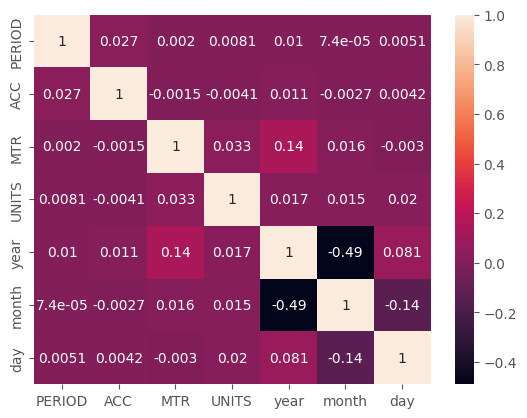

In [17]:
#To understand the relationship between different attributes in the dataset, we will plot a correlation matrix using the following code:

corrMatrix = df.corr() 
sns.heatmap(corrMatrix, annot=True) 
plt.show() 

In [18]:
acc = df['ACC'].value_counts()
tariff_type = df['COD_TARIFF'].value_counts()
units= df['UNITS'].sum()
county = df['COUNTY'].value_counts()

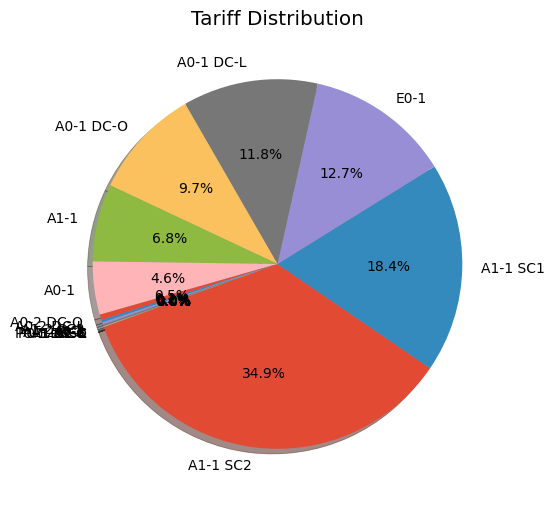

In [19]:
#Pie plot for all the tariffs used 


tariff_counts = df['COD_TARIFF'].value_counts(7)
tariff_counts

plt.figure(figsize=(20,6))
plt.title('Tariff Distribution')
plt.pie(tariff_counts, labels=tariff_counts.index, autopct='%1.1f%%' ,startangle=200, shadow=True);



<AxesSubplot: >

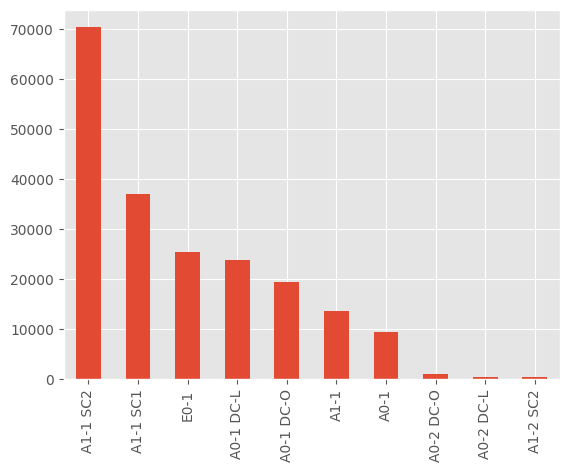

In [20]:
df['COD_TARIFF'].value_counts() \
   .head(10) \
   .plot(kind = 'bar')

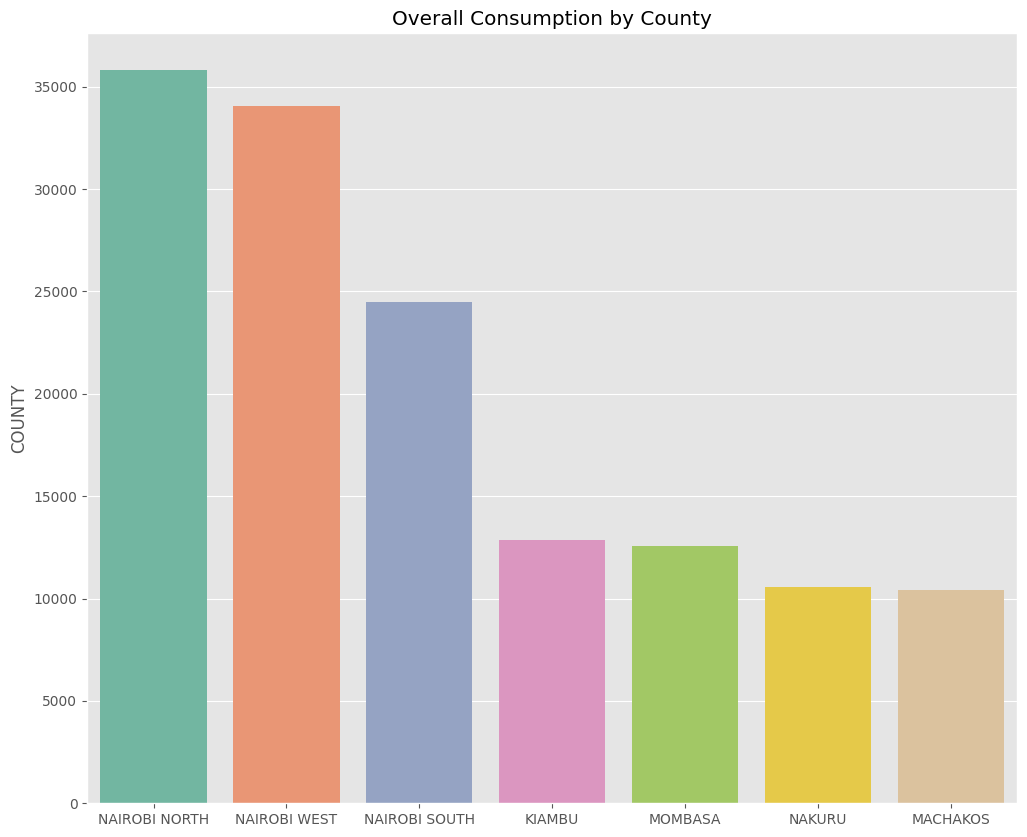

In [21]:
#Counties that consume the most energy by the total units consumed.

top_10_counties= df.COUNTY.value_counts().sort_values(ascending=False).head(7)
top_10_counties

#Plot for the top 10 counties

plt.figure(figsize=(12,10))
#plt.xticks(rotation=20)
plt.title('Overall Consumption by County')
sns.barplot(x=top_10_counties.index, y=top_10_counties, palette='Set2');

# CHANGING THE CATEGORICAL  DATA 

In [22]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder

LabelEncoder presents a problem where an ML algorithm will assume that two nearby values are more similar than two distant values. To prevent this, a method of encoding kmown as one hot encoding is used where only one category presents a one and 0 otherwise. It converts integer categorical values into on-hot vectors. fit_transform() expects a 2D array but house_cat_encoded is a 1D array and therefore needs to be reshaped.

In [23]:
#encoding Columns 

df.replace({'COD_TARIFF':{
"A1-1 SC2"     :0,
"A1-1 SC1"     :1,
"E0-1"         :2,
"A0-1 DC-L"    :3,
"A0-1 DC-O"    :4,
"A1-1"         :5,
"A0-1"         :6,
"A0-2 DC-O"    :7,
"A0-2 DC-L"    :8,
"A1-2 SC2"     :9,
"A0-2"         :10,
"A1-2"         :11,
"A1-2 SC1"     :12,
"P0-1 DC-O"    :13,
"A1-5"         :14,
"A1-5 SC"      :15,
"P1-1 SC"      :16,
"P0-1 DC-L"    :17}},inplace=True) 

In [24]:
#encoding categorical data 

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
le = LabelEncoder()
X= df.iloc[:, 5:6].values  
X[:, 3] = le.fit_transform(X[:, 3])

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
ohe=ColumnTransformer([('OHE',OneHotEncoder(categories='auto'),['REGION'])],remainder='passthrough')
x=ohe.fit_transform(df.drop('COD_TARIFF',axis='columns'))
print(x)


IndexError: index 3 is out of bounds for axis 1 with size 1

In [25]:
#encoding Columns 

df.replace({'COD_TARIFF':{
"A1-1 SC2"     :0,
"A1-1 SC1"     :1,
"E0-1"         :2,
"A0-1 DC-L"    :3,
"A0-1 DC-O"    :4,
"A1-1"         :5,
"A0-1"         :6,
"A0-2 DC-O"    :7,
"A0-2 DC-L"    :8,
"A1-2 SC2"     :9,
"A0-2"         :10,
"A1-2"         :11,
"A1-2 SC1"     :12,
"P0-1 DC-O"    :13,
"A1-5"         :14,
"A1-5 SC"      :15,
"P1-1 SC"      :16,
"P0-1 DC-L"    :17}},inplace=True) 


In [26]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

ohe=ColumnTransformer([('OHE',OneHotEncoder(categories='auto'),['REGION'])],remainder='passthrough')
x=ohe.fit_transform(df[['REGION']])


In [27]:
df_encoded = df.values.reshape(-1,1) 
df_encoded

array([[202102],
       ['COAST'],
       ['MOMBASA'],
       ...,
       [2022],
       [9],
       [14]], dtype=object)

In [57]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
regions = df["REGION"]
regions_encoded = encoder.fit_transform(housing_cat)
regions_encoded



array([1, 5, 5, ..., 1, 1, 1])

In [58]:
print(encoder.classes_)


['CENTRAL RIFT' 'COAST' 'MT KENYA' 'NAIROBI NORTH' 'NAIROBI SOUTH'
 'NAIROBI WEST' 'NORTH EASTERN' 'NORTH RIFT' 'SOUTH NYANZA' 'WEST KENYA']


LabelEncoder presents a problem where an ML algorithm will assume that two nearby values are more similar than two distant values. To prevent this, a method of encoding kmown as one hot encoding is used where only one category presents a one and 0 otherwise. It converts integer categorical values into on-hot vectors. fit_transform() expects a 2D array but house_cat_encoded is a 1D array and therefore needs to be reshaped.

In [59]:
regions_encoded = df.values.reshape(-1,1) 
regions_encoded

array([[202102],
       ['COAST'],
       ['MOMBASA'],
       ...,
       [2022],
       [9],
       [14]], dtype=object)

In [29]:
#dropping the first column to avoid dummy variable trap

x=x[:,1:]
x


<201408x9 sparse matrix of type '<class 'numpy.float64'>'
	with 187302 stored elements in Compressed Sparse Row format>

# SPLITTING THE DATASET

In [67]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names].values

In [68]:
df.isnull().sum()

PERIOD               0
REGION               0
COUNTY               0
ACC                  0
MTR                  0
COD_TARIFF           0
INSTALLATION_DATE    0
UNITS                0
year                 0
month                0
day                  0
dtype: int64

In [31]:
#Identifying the independent variable

X= df.iloc[:, 5:6].values  
X

array([[3],
       [6],
       [6],
       ...,
       [1],
       [1],
       [1]])

In [32]:
#Identifying the dependent variable

Y = df.iloc[:, 7:8].values 
Y

array([[  0.],
       [ 54.],
       [100.],
       ...,
       [  0.],
       [  0.],
       [  0.]])

In [33]:
X = df.iloc[:, 5:6].values 
Y = df.iloc[:, 7:8].values 


In [34]:
#Separating dataset


from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42) 

In [35]:
X.shape, Y.shape

((201408, 1), (201408, 1))

In [36]:
X_train.shape, Y_train.shape

((161126, 1), (161126, 1))

In [37]:
X_test.shape, Y_test.shape

((40282, 1), (40282, 1))

In [38]:
#check the requirements of the model we are building to see if the data needs to be scaled.

from sklearn.preprocessing import StandardScaler
standardized = StandardScaler().fit_transform(X_train)
standardized[~np.isnan(standardized)][:30]

array([-0.95670858, -0.44978756,  1.57789652, -0.44978756, -0.95670858,
        0.56405448, -0.44978756, -0.95670858, -0.95670858,  1.57789652,
       -0.95670858,  1.0709755 , -0.44978756,  0.05713346,  0.56405448,
        2.59173856,  1.57789652, -0.95670858, -0.44978756,  0.56405448,
       -0.95670858,  0.05713346,  1.0709755 , -0.95670858,  0.05713346,
        0.56405448,  0.56405448, -0.95670858, -0.95670858,  0.56405448])

In [39]:
# preprocessing module for min-max scaling (to normalize data to be in [0, 1]), among others.

from sklearn.preprocessing import MinMaxScaler
MinMaxScaler().fit_transform(X_train)


array([[0.        ],
       [0.05882353],
       [0.29411765],
       ...,
       [0.11764706],
       [0.        ],
       [0.11764706]])

In [40]:
#Fitting multiple linear regression to training set 

from sklearn.linear_model import LinearRegression
model_fit = LinearRegression()
model_fit.fit(X_train, Y_train)

LinearRegression()

In [41]:
# loading the linear regression model 
lin_reg_model = LinearRegression() 

# Now we can fit the model to our dataset 
lin_reg_model.fit(X_train,Y_train) 

LinearRegression()

In [42]:
#inspect the intercept 
print('Intercepts: ', lin_reg_model.intercept_)


Intercepts:  [994.66657044]


In [43]:
#inspect the coefficient
print('Coefficients: ', lin_reg_model.coef_)

Coefficients:  [[-131.46498043]]


In [44]:
# variance score: 1 means perfect prediction
print('Variance score: {}'.format(lin_reg_model.score(X_test, Y_test)))
  


Variance score: 0.005963605439833652


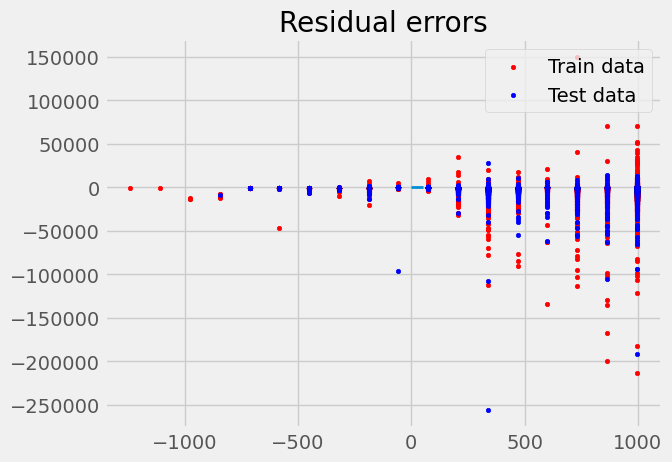

In [45]:
# plot for residual error
  
## setting plot style
plt.style.use('fivethirtyeight')
  
## plotting residual errors in training data
plt.scatter(lin_reg_model.predict(X_train), lin_reg_model.predict(X_train) - Y_train,
            color = "red", s = 10, label = 'Train data')
  
## plotting residual errors in test data
plt.scatter(lin_reg_model.predict(X_test), lin_reg_model.predict(X_test) - Y_test,
            color = "blue", s = 10, label = 'Test data')
  
## plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
  
## plotting legend
plt.legend(loc = 'upper right')
  
## plot title
plt.title("Residual errors")
  
## method call for showing the plot
plt.show()